In [1222]:
import math
from math import sqrt

#Data management
import joblib
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import pandas_profiling
from time import time
from pandas.api.types import CategoricalDtype
#plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go
import plotly.express as px

#sci-kit learn
from sklearn.feature_selection import RFE, VarianceThreshold, SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


#Definitions
#

#print results of tunning hyperparameters
def print_results(results):
    print('Best params: {}\n' .format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,3), round(std * 2, 3), params))
    
    
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict (features)
    end = time()
    accuracy = round(accuracy_score(labels,pred),3)
    precision = round(precision_score(labels,pred,average='micro'),3)
    recall = round(recall_score(labels,pred,average='micro'),3)
    print('{} / Accuracy {} / Precision {} / Recall {} / Latency {} ms'.format(name,accuracy,precision,recall,round (end-start)) )
    



In [1223]:
trainset  = pd.read_csv('train.csv')
tweets = pd.read_csv('tweets_from2015_#Ibex35.csv')
testset = pd.read_csv('test_x.csv')

In [1224]:

trainset.drop_duplicates(inplace=True)
trainset.dropna(inplace=True)
trainsetND=trainset.drop("Date", axis=1)

In [1225]:
#Se da un formato más manejable para el volumen
trainsetND['Volume']=trainsetND['Volume']/100000

In [1226]:
trainsetND

,Open,High,Low,Close,Adj Close,Volume,Target
0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.000,0
1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.000,1
2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.000,1
4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.000,1
5,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.000,1
...,...,...,...,...,...,...,...
6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,1216.731,0
6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,601.780,0
6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,2189.008,0
6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,1489.871,0


In [1227]:
#Se calcula las diferencia entre distintos puntos de la vela que se forma con los datos
trainsetND['diffCO']=trainsetND['Close']-trainsetND['Open']
trainsetND['diffACO']=trainsetND['Adj Close']-trainsetND['Open']
trainsetND['diffHL']=trainsetND['High']-trainsetND['Low']
trainsetND['diffHO']=trainsetND['High']-trainsetND['Open']
trainsetND['diffOL']=trainsetND['Open']-trainsetND['Low']
trainsetND['diffHC']=trainsetND['High']-trainsetND['Adj Close']
trainsetND['diffLC']=trainsetND['Low']-trainsetND['Adj Close']


In [1228]:
#Se eliminan unos cuantos outliers
trainsetND = trainsetND.drop(trainsetND[trainsetND['Volume']>5000].index)
#Eliminamos un volumen bajo porque no da información relevante del mercado
trainsetND = trainsetND.drop(trainsetND[trainsetND['Volume']<1000].index)
trainsetND = trainsetND.drop(trainsetND[trainsetND['diffHC']>225].index)
trainsetND = trainsetND.drop(trainsetND[trainsetND['diffOL']>225].index)
#trainsetND = trainsetND.drop(trainsetND[trainsetND['diffHL']<100].index)
#trainsetND = trainsetND.drop(trainsetND[trainsetND['diffHL']>350].index)



In [1229]:
trainsetND['UpDown'] = ((trainsetND['Adj Close']>trainsetND['Open'])*1).astype('category')
trainsetND['VolumeDump'] = ((trainsetND['Volume']>2750)*1).astype('category')
trainsetND['Color']=trainsetND['diffACO']>0
trainsetND['Alcista']=((trainsetND['diffOL']<100)&(trainsetND['diffHC']<50)*1).astype('str')
trainsetND['diffOLDump'] = ((trainsetND['diffOL']<100)*1).astype('category')








In [1230]:
#Discretizamos la varaible volumen, la decisión que se ha tomado ha sido observando los gráficos siguientes
trainsetND['bins'] = (pd.cut(x=trainsetND['Volume'], bins=[1, 1750, 2750, 5000],labels=['0','1','2'])).astype('str')
trainsetND['bins']

4311    0
4312    0
4314    0
4315    0
4317    1
       ..
6548    0
6549    0
6551    1
6552    0
6553    0
Name: bins, Length: 2036, dtype: object

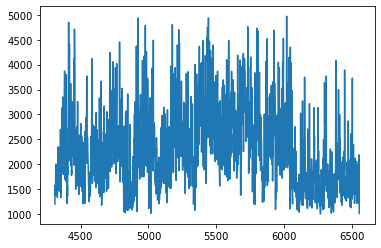

In [1231]:
plt.plot(trainsetND['Volume'])

<AxesSubplot:xlabel='Target', ylabel='Volume'>

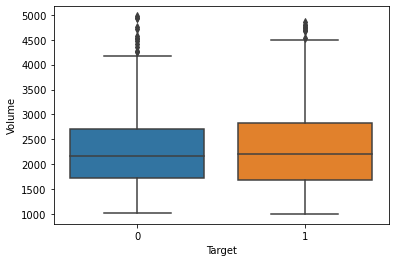

In [1232]:
sns.boxplot(x="Target", y="Volume", data=trainsetND)

<AxesSubplot:ylabel='Volume'>

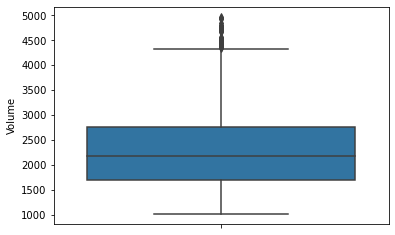

In [1233]:
sns.boxplot(y="Volume", data=trainsetND)

<AxesSubplot:ylabel='diffHL'>

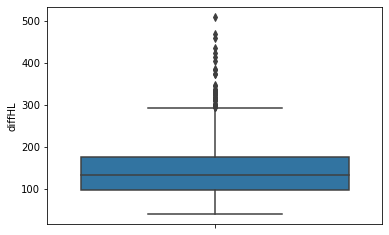

In [1234]:
sns.boxplot(y="diffHL", data=trainsetND)

<AxesSubplot:ylabel='diffOL'>

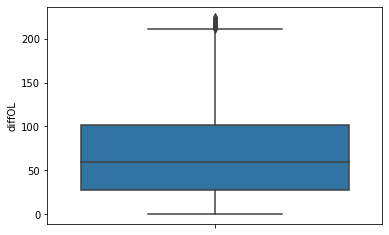

In [1235]:
sns.boxplot(y="diffOL", data=trainsetND)

<AxesSubplot:xlabel='Target', ylabel='diffOL'>

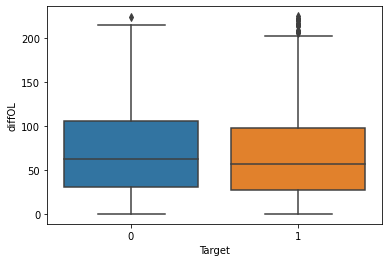

In [1236]:
sns.boxplot(x="Target", y="diffOL", data=trainsetND)

<AxesSubplot:xlabel='Target', ylabel='diffHC'>

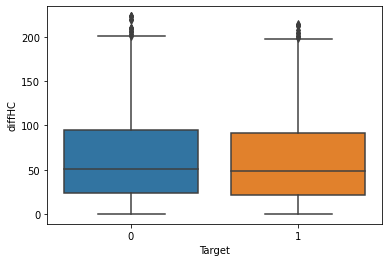

In [1237]:
sns.boxplot(x="Target", y="diffHC", data=trainsetND)

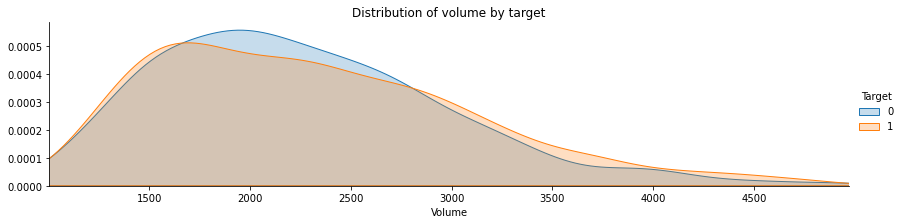

In [1238]:
fig = sns.FacetGrid(trainsetND, hue='Target', aspect=4)
fig.map(sns.kdeplot, 'Volume', shade=True)
oldest = trainsetND['Volume'].max()
minim = trainsetND['Volume'].min()
fig.set(xlim=(minim,oldest))
fig.set(title='Distribution of volume by target')
fig.add_legend()

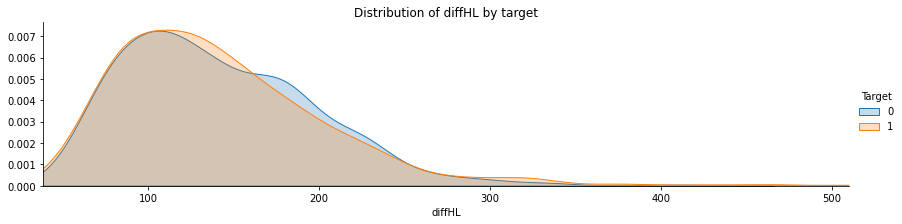

In [1239]:
fig = sns.FacetGrid(trainsetND, hue='Target', aspect=4)
fig.map(sns.kdeplot, 'diffHL', shade=True)
oldest = trainsetND['diffHL'].max()
minim = trainsetND['diffHL'].min()
fig.set(xlim=(minim,oldest))
fig.set(title='Distribution of diffHL by target')
fig.add_legend()

In [1240]:
trainsetND

,Open,High,Low,Close,Adj Close,Volume,Target,diffCO,diffACO,diffHL,diffHO,diffOL,diffHC,diffLC,UpDown,VolumeDump,Color,Alcista,diffOLDump,bins
4311,10117.099609,10306.200195,10087.700195,10221.200195,10221.189453,1199.380,0,104.100586,104.089844,218.500000,189.100586,29.399414,85.010742,-133.489258,1,0,True,False,1,0
4312,10129.500000,10140.700195,9954.799805,10052.299805,10052.290039,1579.790,1,-77.200195,-77.209961,185.900390,11.200195,174.700195,88.410156,-97.490234,0,0,False,False,0,0
4314,9992.799805,10056.400391,9934.799805,10004.400391,10004.390625,1380.390,1,11.600586,11.590820,121.600586,63.600586,58.000000,52.009766,-69.590820,1,0,True,False,1,0
4315,9951.299805,10164.799805,9938.099609,10148.200195,10148.189453,1481.660,1,196.900390,196.889648,226.700196,213.500000,13.200196,16.610352,-210.089844,1,0,True,True,1,0
4317,9980.900391,10187.000000,9964.200195,10187.000000,10186.989258,1811.260,1,206.099609,206.088867,222.799805,206.099609,16.700196,0.010742,-222.789063,1,0,True,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6548,9170.700195,9186.700195,9098.400391,9114.000000,9114.000000,1610.943,1,-56.700195,-56.700195,88.299804,16.000000,72.299804,72.700195,-15.599609,0,0,False,False,1,0
6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,1216.731,0,24.299804,24.299804,69.699218,60.799804,8.899414,36.500000,-33.199218,1,0,True,True,1,0
6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,2189.008,0,-28.600586,-28.600586,92.000000,4.500000,87.500000,33.100586,-58.899414,0,0,False,True,1,1
6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,1489.871,0,-32.700195,-32.700195,81.600586,3.500000,78.100586,36.200195,-45.400391,0,0,False,True,1,0


In [1241]:
testset

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [1242]:
X=trainsetND[['bins','Adj Close','Open']]
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
pca=PCA(n_components=3)
pca.fit(X)
np.sum(pca.explained_variance_ratio_)

1.0

In [1243]:
X

array([[-1.35279796,  0.64626091,  0.55864697],
       [-1.35279796,  0.49524293,  0.56969059],
       [-1.35279796,  0.45241464,  0.44794729],
       ...,
       [ 0.02780186, -0.27414691, -0.23994093],
       [-1.35279796, -0.37366336, -0.33541194],
       [-1.35279796, -0.30454731, -0.32864384]])

In [1244]:
new_values=pca.transform(X)


In [1245]:
new_values

array([[-0.78360033, -1.39314797,  0.07007979],
       [-0.68472942, -1.38889818, -0.04452768],
       [-0.56851224, -1.38277447,  0.01125549],
       ...,
       [ 0.3616836 ,  0.04572186, -0.02440504],
       [ 0.56812488, -1.32629423, -0.01911893],
       [ 0.51452674, -1.32870487,  0.02497488]])

In [1246]:
features=new_values
labels=trainsetND['Target']
X_train, X_test, y_train, y_test= train_test_split (features, labels, test_size = 0.4, random_state=1)
X_test, X_val, y_test, y_val= train_test_split (X_test, y_test, test_size = 0.5, random_state=1)


In [1247]:
features

array([[-0.78360033, -1.39314797,  0.07007979],
       [-0.68472942, -1.38889818, -0.04452768],
       [-0.56851224, -1.38277447,  0.01125549],
       ...,
       [ 0.3616836 ,  0.04572186, -0.02440504],
       [ 0.56812488, -1.32629423, -0.01911893],
       [ 0.51452674, -1.32870487,  0.02497488]])

In [1248]:
##Random Forest
rf= RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100,250],
    'max_depth': [2,4,6,8,16,32,None],
}

cv=GridSearchCV(rf,parameters, cv=5,n_jobs = -1)
cv.fit(X_train, y_train.values.ravel())
print_results(cv)
joblib.dump(cv.best_estimator_,'RF_Hackathon.pkl')
##KNN
knn = KNeighborsClassifier()
parameters = {
    'n_neighbors': [1,3,5,7],
}
cv=GridSearchCV(knn,parameters, cv=5,n_jobs = -1)
cv.fit(X_train, y_train.values.ravel())
print_results(cv)

joblib.dump(cv.best_estimator_,'knn_Hackathon.pkl')

Best params: {'max_depth': 4, 'n_estimators': 100}

0.509 (+/-0.029) for {'max_depth': 2, 'n_estimators': 5}
0.536 (+/-0.023) for {'max_depth': 2, 'n_estimators': 50}
0.528 (+/-0.03) for {'max_depth': 2, 'n_estimators': 100}
0.531 (+/-0.022) for {'max_depth': 2, 'n_estimators': 250}
0.532 (+/-0.039) for {'max_depth': 4, 'n_estimators': 5}
0.523 (+/-0.021) for {'max_depth': 4, 'n_estimators': 50}
0.542 (+/-0.029) for {'max_depth': 4, 'n_estimators': 100}
0.531 (+/-0.053) for {'max_depth': 4, 'n_estimators': 250}
0.504 (+/-0.061) for {'max_depth': 6, 'n_estimators': 5}
0.518 (+/-0.089) for {'max_depth': 6, 'n_estimators': 50}
0.516 (+/-0.065) for {'max_depth': 6, 'n_estimators': 100}
0.521 (+/-0.043) for {'max_depth': 6, 'n_estimators': 250}
0.527 (+/-0.058) for {'max_depth': 8, 'n_estimators': 5}
0.518 (+/-0.078) for {'max_depth': 8, 'n_estimators': 50}
0.522 (+/-0.058) for {'max_depth': 8, 'n_estimators': 100}
0.518 (+/-0.081) for {'max_depth': 8, 'n_estimators': 250}
0.513 (+/-0.031) 

['knn_Hackathon.pkl']

In [1249]:
##Compare models
models = {}
for mdl in ['RF','knn']:
  models[mdl]=joblib.load('{}_Hackathon.pkl'.format(mdl))
for name, mdl in models.items():
  evaluate_model(name,mdl, X_val,y_val)

RF / Accuracy 0.561 / Precision 0.561 / Recall 0.561 / Latency 0 ms
knn / Accuracy 0.581 / Precision 0.581 / Recall 0.581 / Latency 0 ms


In [1250]:
estimators=[('rf',RandomForestClassifier(max_depth= 8, n_estimators=50)),('knn',KNeighborsClassifier(n_neighbors=3))]
sc=StackingClassifier(estimators=estimators)
parameters={
    'passthrough': [True, False],
    'final_estimator': [LogisticRegression(C=1),LogisticRegression(C=0.1)]
}
cv=GridSearchCV(sc,parameters,cv=5,n_jobs = -1)
cv.fit(X_train, y_train.values.ravel())
print_results(cv)

joblib.dump(cv.best_estimator_,'sc_Hackathon.pkl')

Best params: {'final_estimator': LogisticRegression(C=0.1), 'passthrough': False}

0.532 (+/-0.019) for {'final_estimator': LogisticRegression(C=1), 'passthrough': True}
0.555 (+/-0.043) for {'final_estimator': LogisticRegression(C=1), 'passthrough': False}
0.538 (+/-0.021) for {'final_estimator': LogisticRegression(C=0.1), 'passthrough': True}
0.562 (+/-0.054) for {'final_estimator': LogisticRegression(C=0.1), 'passthrough': False}


['sc_Hackathon.pkl']

In [1251]:
##Compare models
models = {}
for mdl in ['RF','knn','sc']:
  models[mdl]=joblib.load('{}_Hackathon.pkl'.format(mdl))
for name, mdl in models.items():
  evaluate_model(name,mdl, X_val,y_val)

RF / Accuracy 0.561 / Precision 0.561 / Recall 0.561 / Latency 0 ms
knn / Accuracy 0.581 / Precision 0.581 / Recall 0.581 / Latency 0 ms
sc / Accuracy 0.581 / Precision 0.581 / Recall 0.581 / Latency 0 ms


In [1252]:
testset['Volume']=testset['Volume']/100000.0

In [1253]:
testset['bins'] = (pd.cut(x=testset['Volume'], bins=[1, 1750, 2750, 5000],labels=['0','1','2'])).astype('object')
testset['bins']

0      0
1      1
2      0
3      0
4      0
      ..
721    0
722    0
723    1
724    1
725    1
Name: bins, Length: 726, dtype: object

In [1254]:
testset['Open']=testset['Open'].astype('float32')
testset['Adj Close']=testset['Adj Close'].astype('float32')

In [1255]:
testset=testset.fillna(0)

In [1256]:
X=testset[['bins','Adj Close','Open']]
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
pca=PCA(n_components=3)
pca.fit(X)
np.sum(pca.explained_variance_ratio_)
new_values=pca.transform(X)

In [1257]:
features=new_values
model=joblib.load('sc_Hackathon.pkl')
testset['Target']=model.predict(features)

In [1258]:
testset['Target']

0      0
1      1
2      1
3      1
4      1
      ..
721    1
722    1
723    1
724    0
725    0
Name: Target, Length: 726, dtype: int64

In [1259]:
predictions=testset[['test_index','Target']]
predictions.to_csv('prediction.csv',index=False)
predictions.to_json('predictions.json')